# Movie Recommender

In [ ]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rounakbanik/the-movies-dataset

     |████████████████████████████████| 61kB 2.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp37-none-any.whl size=73269 sha256=88eaf6afc105c888ac21555e344c4939bcbf57228092b455530d7dc0690a40fa
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10
 99% 225M/228M [00:03<00:00, 73.2MB/s]
100% 228M/228M [00:03<00:00, 73.5MB/s]


In [ ]:
!unzip the-movies-dataset.zip

Archive:  the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('movies_metadata.csv')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


## Simple Recommender

The choice of a metric is arbitrary. One of the simplest metrics that can be used is the movie rating. However, this suffers from a variety of disadvantages. In the first place, the movie rating does not take the popularity of a movie into consideration. Therefore, a movie rated 9 by 100,000 users will be placed below a movie rated 9.5 by 100 users.
This is not desirable as it is highly likely that a movie watched and rated only by 100 people caters to a very specific niche and may not appeal as much to the average person as the former.

It is also a well-known fact that as the number of voters increase, the rating of a movie normalizes and it approaches a value that is reflective of the movie's quality and popularity with the general populace. To put it another way, movies with very few ratings are not very reliable. A movie rated 10/10 by five users doesn't necessarily mean that it's a good movie.

Therefore, what we need is a metric that can, to an extent, take into account the movie rating and the number of votes it has garnered (a proxy for popularity). This would give a greater preference to a blockbuster movie rated 8 by 100,000 users over an art house movie rated 9 by 100 users.

Fortunately, we do not have to brainstorm a mathematical formula for the metric. As the title of this chapter states, we are building an IMDB top 250 clone. Therefore, we shall use IMDB's weighted rating formula as our metric. Mathematically, it can be represented as follows:

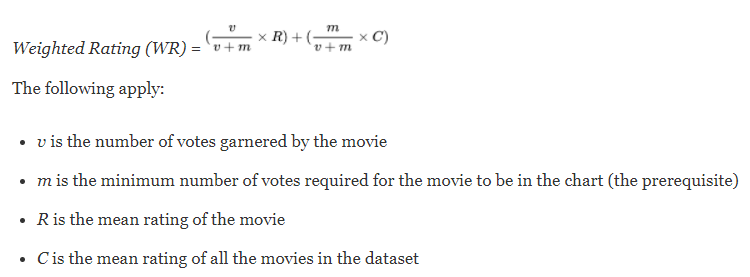

For our recommender, we will use the number of votes garnered by the 80th percentile movie as our value for m. In other words, for a movie to be considered in the rankings, it must have garnered more votes than at least 80% of the movies present in our dataset. Additionally, the number of votes garnered by the 80th percentile movie is used in the weighted formula to come up with the value for the scores.

In [ ]:
#Calculate the number of votes garnered by the 80th percentile movie
m = df['vote_count'].quantile(0.80)
m

50.0

We can see that only 20% of the movies have gained more than 50 votes. Therefore, our value of m is 50.

Another prerequisite that we want in place is the runtime. We will only consider movies that are greater than 45 minutes and less than 300 minutes in length. Let us define a new DataFrame, q_movies, which will hold all the movies that qualify to appear in the chart:

In [ ]:
#Only consider movies longer than 45 minutes and shorter than 300 minutes
q_movies = df[(df['runtime'] >= 45) & (df['runtime'] <= 300)]

#Only consider movies that have garnered more than m votes
q_movies = q_movies[q_movies['vote_count'] >= m]

#Inspect the number of movies that made the cut
q_movies.shape

(8963, 24)

We see that from our dataset of 45,000 movies approximately 9,000 movies (or 20%) made the cut. 

Let's calculate C, the mean rating for all the movies in the dataset:

In [ ]:
# Calculate C
C = df['vote_average'].mean()
C

5.618207215133889

We can see that the average rating of a movie is approximately 5.6/10. It seems that IMDB happens to be particularly strict with their ratings. Now that we have the value of C, we can go about calculating our score for each movie.

First, let us define a function that computes the rating for a movie, given its features and the values of m and C:

In [ ]:
# Function to compute the IMDB weighted rating for each movie
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Compute the weighted score
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
# Compute the score using the weighted_rating function defined above
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

#Sort movies in descending order of their scores
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 25 movies
q_movies[['title', 'vote_count', 'vote_average', 'score', 'runtime']].head(25)

,title,vote_count,vote_average,score,runtime
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.855148,190.0
314,The Shawshank Redemption,8358.0,8.5,8.482863,142.0
834,The Godfather,6024.0,8.5,8.476278,175.0
40251,Your Name.,1030.0,8.5,8.366584,106.0
12481,The Dark Knight,12269.0,8.3,8.289115,152.0
2843,Fight Club,9678.0,8.3,8.286216,139.0
292,Pulp Fiction,8670.0,8.3,8.284623,154.0
522,Schindler's List,4436.0,8.3,8.270109,195.0
23673,Whiplash,4376.0,8.3,8.269704,105.0
5481,Spirited Away,3968.0,8.3,8.266628,125.0


We can see that the Bollywood film Dilwale Dulhania Le Jayenge figures at the top of the list. We can also see that it has a noticeably smaller number of votes than the other Top 25 movies. This strongly suggests that we should probably explore a higher value of m.

## Knowledge-based Recommender

This will be a simple function that will perform the following tasks:
- Ask the user for the genres of movies he/she is looking for
- Ask the user for the duration
- Ask the user for the timeline of the movies recommended
- Using the information collected, recommend movies to the user that have a high weighted rating (according to the IMDB formula) and that satisfy the preceding conditions

The data that we have has information on the duration, genres, and timelines, but it isn't currently in a form that is directly usable. In other words, our data needs to be wrangled before it can be put to use to build this recommender.

In [ ]:
#Only keep those features that we require 
df = df[['title','genres', 'release_date', 'runtime', 'vote_average', 'vote_count']]

df.head()

,title,genres,release_date,runtime,vote_average,vote_count
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1995-10-30,81.0,7.7,5415.0
1,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",1995-12-15,104.0,6.9,2413.0
2,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",1995-12-22,101.0,6.5,92.0
3,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995-12-22,127.0,6.1,34.0
4,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",1995-02-10,106.0,5.7,173.0


Next, let us extract the year of release from our release_date feature:

In [ ]:
#Convert release_date into pandas datetime format
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

#Extract year from the datetime
df['year'] = df['release_date'].apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

#Helper function to convert NaT to 0 and all other years to integers.
def convert_int(x):
    try:
        return int(x)
    except:
        return 0

#Apply convert_int to the year feature
df['year'] = df['year'].apply(convert_int)

#Drop the release_date column
df = df.drop('release_date', axis=1)

#Display the dataframe
df.head()

,title,genres,runtime,vote_average,vote_count,year
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",81.0,7.7,5415.0,1995
1,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",104.0,6.9,2413.0,1995
2,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",101.0,6.5,92.0,1995
3,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",127.0,6.1,34.0,1995
4,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",106.0,5.7,173.0,1995


Upon preliminary inspection, we can observe that the genres are in a format that looks like a JSON object (or a Python dictionary). Let us take a look at the genres object of one of our movies:

In [ ]:
#Print genres of the first movie
df.iloc[0]['genres']

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

We can observe that the output is a stringified dictionary. In order for this feature to be usable, it is important that we convert this string into a native Python dictionary. Fortunately, Python gives us access to a function called literal_eval (available in the ast library) which does exactly that. literal_eval parses any string passed into it and converts it into its corresponding Python object.

Also, each dictionary represents a genre and has two keys: id and name. However, for this exercise (as well as all subsequent exercises), we only require the name. Therefore, we shall convert our list of dictionaries into a list of strings, where each string is a genre name:

In [ ]:
#Import the literal_eval function from ast
from ast import literal_eval

#Convert all NaN into stringified empty lists
df['genres'] = df['genres'].fillna('[]')

#Apply literal_eval to convert to the list object
df['genres'] = df['genres'].apply(literal_eval)

#Convert list of dictionaries to a list of strings
df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

df.head()

,title,genres,runtime,vote_average,vote_count,year
0,Toy Story,"[Animation, Comedy, Family]",81.0,7.7,5415.0,1995
1,Jumanji,"[Adventure, Fantasy, Family]",104.0,6.9,2413.0,1995
2,Grumpier Old Men,"[Romance, Comedy]",101.0,6.5,92.0,1995
3,Waiting to Exhale,"[Comedy, Drama, Romance]",127.0,6.1,34.0,1995
4,Father of the Bride Part II,[Comedy],106.0,5.7,173.0,1995


The last step is to explode the genres column. In other words, if a particular movie has multiple genres, we will create multiple copies of the movie, with each movie having one of the genres.

In [ ]:
#Create a new feature by exploding genres
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)

#Name the new feature as 'genre'
s.name = 'genre'

#Create a new dataframe gen_df which by dropping the old 'genres' feature and adding the new 'genre'.
gen_df = df.drop('genres', axis=1).join(s)

#Print the head of the new gen_df
gen_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,title,runtime,vote_average,vote_count,year,genre
0,Toy Story,81.0,7.7,5415.0,1995,Animation
0,Toy Story,81.0,7.7,5415.0,1995,Comedy
0,Toy Story,81.0,7.7,5415.0,1995,Family
1,Jumanji,104.0,6.9,2413.0,1995,Adventure
1,Jumanji,104.0,6.9,2413.0,1995,Fantasy


build_chart function
1. Get user input on their preferences
2. Extract all movies that match the conditions set by the user
3. Calculate the values of m and C for only these movies and proceed to build the chart

In [ ]:
def build_chart(gen_df, percentile=0.8):
    #Ask for preferred genres
    print("Input preferred genre")
    genre = input()
    
    #Ask for lower limit of duration
    print("Input shortest duration")
    low_time = int(input())
    
    #Ask for upper limit of duration
    print("Input longest duration")
    high_time = int(input())
    
    #Ask for lower limit of timeline
    print("Input earliest year")
    low_year = int(input())
    
    #Ask for upper limit of timeline
    print("Input latest year")
    high_year = int(input())
    
    #Define a new movies variable to store the preferred movies. Copy the contents of gen_df to movies
    movies = gen_df.copy()
    
    #Filter based on the condition
    movies = movies[(movies['genre'] == genre) & 
                    (movies['runtime'] >= low_time) & 
                    (movies['runtime'] <= high_time) & 
                    (movies['year'] >= low_year) & 
                    (movies['year'] <= high_year)]
    
    #Compute the values of C and m for the filtered movies
    C = movies['vote_average'].mean()
    m = movies['vote_count'].quantile(percentile)
    
    #Only consider movies that have higher than m votes. Save this in a new dataframe q_movies
    q_movies = movies.copy().loc[movies['vote_count'] >= m]
    
    #Calculate score using the IMDB formula
    q_movies['score'] = q_movies.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) 
                                       + (m/(m+x['vote_count']) * C)
                                       ,axis=1)

    #Sort movies in descending order of their scores
    q_movies = q_movies.sort_values('score', ascending=False)
    
    return q_movies

In [ ]:
#Generate the chart for top animation movies and display top 5.
build_chart(gen_df).head()

Input preferred genre
Action
Input shortest duration
80
Input longest duration
120
Input earliest year
1990
Input latest year
2000


,title,runtime,vote_average,vote_count,year,genre,score
723,Ghost in the Shell,83.0,7.8,854.0,1995,Action,7.521643
550,True Romance,120.0,7.5,762.0,1993,Action,7.231980
3902,"O Brother, Where Art Thou?",106.0,7.3,1144.0,2000,Action,7.131617
348,The Crow,102.0,7.3,980.0,1994,Action,7.106412
3871,"Crouching Tiger, Hidden Dragon",120.0,7.2,949.0,2000,Action,7.011634


We can see that the movies that it outputs satisfy all the conditions we passed in as input. Since we applied IMDB's metric, we can also observe that our movies are very highly rated and popular at the same time.

## Content-based Recommender

The simple recommender did not take into consideration an individual user's preferences. The knowledge-based recommender did take account of the user's preference for genres, timelines, and duration, but the model and its recommendations still remained very generic. Imagine that Alice likes the movies The Dark Knight, Iron Man, and Man of Steel. It is pretty evident that Alice has a taste for superhero movies. However, our models would not be able to capture this detail. The best it could do is suggest action movies (by making Alice input action as the preferred genre), which is a superset of superhero movies.

It is also possible that two movies have the same genre, timeline, and duration characteristics, but differ hugely in their audience. Consider The Hangover and Forgetting Sarah Marshall, for example. Both these movies were released in the first decade of the 21st century, both lasted around two hours, and both were comedies. However, the kind of audience that enjoyed these movies was very different.

We are going to build two types of content-based recommender:
1. Plot description-based recommender: This model compares the descriptions and taglines of different movies, and provides recommendations that have the most similar plot descriptions.
2. Metadata-based recommender: This model takes a host of features, such as genres, keywords, cast, and crew, into consideration and provides recommendations that are the most similar with respect to the aforementioned features.

### Plot description-based recommender

In [ ]:
#Import the original file
orig_df = pd.read_csv('movies_metadata.csv', low_memory=False)

#Add the useful features into the cleaned dataframe
df['overview'], df['id'] = orig_df['overview'], orig_df['id']

df.head()

,title,genres,runtime,vote_average,vote_count,year,overview,id
0,Toy Story,"['Animation', 'Comedy', 'Family']",81.0,7.7,5415.0,1995,"Led by Woody, Andy's toys live happily in his ...",862
1,Jumanji,"['Adventure', 'Fantasy', 'Family']",104.0,6.9,2413.0,1995,When siblings Judy and Peter discover an encha...,8844
2,Grumpier Old Men,"['Romance', 'Comedy']",101.0,6.5,92.0,1995,A family wedding reignites the ancient feud be...,15602
3,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']",127.0,6.1,34.0,1995,"Cheated on, mistreated and stepped on, the wom...",31357
4,Father of the Bride Part II,['Comedy'],106.0,5.7,173.0,1995,Just when George Banks has recovered from his ...,11862


In [ ]:
#Import TfIdfVectorizer from the scikit-learn library
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stopwords
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df['overview'] = df['overview'].fillna('')

#Construct the required TF-IDF matrix by applying the fit_transform method on the overview feature
tfidf_matrix = tfidf.fit_transform(df['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix

<45466x75827 sparse matrix of type '<class 'numpy.float64'>'
	with 1210882 stored elements in Compressed Sparse Row format>

We see that the vectorizer has created a 75,827-dimensional vector for the overview of every movie.

The next step is to calculate the pairwise cosine similarity score of every movie. In other words, we are going to create a 45,466 × 45,466 matrix, where the cell in the ith row and jth column represents the similarity score between movies i and j. We can easily see that this matrix is symmetric in nature and every element in the diagonal is 1, since it is the similarity score of the movie with itself.

In [ ]:
# Import linear_kernel to compute the dot product
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
#Construct a reverse mapping of indices and movie titles, and drop duplicate titles, if any
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

In [ ]:
# Function that takes in movie title as input and gives recommendations 
def content_recommender(title, tfidf_matrix=tfidf_matrix, df=df, indices=indices):
    # Obtain the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    # And convert it into a list of tuples as described above
    sim_scores = list(enumerate(linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()))

    # Sort the movies based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies. Ignore the first movie.
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [ ]:
#Get recommendations for The Lion King
content_recommender('The Lion King')

34682    How the Lion Cub and the Turtle Sang a Song
9353                                The Lion King 1½
9115                  The Lion King 2: Simba's Pride
42829                                           Prey
25654                                 Fearless Fagan
17041                                   African Cats
27933              Massaï, les guerriers de la pluie
6094                                       Born Free
37409                                     Sour Grape
3203                                The Waiting Game
Name: title, dtype: object

We see that our recommender has suggested all of The Lion King's sequels in its top-10 list. We also notice that most of the movies in the list have to do with lions.

It goes without saying that a person who loves The Lion King is very likely to have a thing for Disney movies. They may also prefer to watch animated movies. Unfortunately, our plot description recommender isn't able to capture all this information.

Therefore, in the next section, we will build a recommender that uses more advanced metadata, such as genres, cast, crew, and keywords (or sub-genres). This recommender will be able to do a much better job of identifying an individual's taste for a particular director, actor, sub-genre, and so on.

### Metadata-based recommender

To build this model, we will be using the following metdata:
- The genre of the movie. 
- The director of the movie. This person is part of the crew.
- The movie's three major stars. They are part of the cast.
- Sub-genres or keywords.

In [ ]:
# Load the keywords and credits files
cred_df = pd.read_csv('credits.csv')
key_df = pd.read_csv('keywords.csv')

In [ ]:
#Print the head of the credit dataframe
cred_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [ ]:
#Print the head of the keywords dataframe
key_df.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


We can see that the cast, crew, and the keywords are in the familiar list of dictionaries form. Just like genres, we have to reduce them to a string or a list of strings.

Before we do this, however, we will join the three DataFrames so that all our features are in a single DataFrame. Joining pandas DataFrames is identical to joining tables in SQL. The key we're going to use to join the DataFrames is the id feature. However, in order to use this, we first need to explicitly convert is listed as an ID. This is clearly bad data. 

In [ ]:
#Convert the IDs of df into int
df['id'] = df['id'].astype('float').astype('int')

image.png

In [ ]:
# Function to convert all non-integer IDs to NaN
def clean_ids(x):
    try:
        return int(x)
    except:
        return np.nan

#Clean the ids of df
df['id'] = df['id'].apply(clean_ids)

#Filter all rows that have a null ID
df = df[df['id'].notnull()]

# Convert IDs into integer
df['id'] = df['id'].astype('int')
key_df['id'] = key_df['id'].astype('int')
cred_df['id'] = cred_df['id'].astype('int')

# Merge keywords and credits into your main metadata dataframe
df = df.merge(cred_df, on='id')
df = df.merge(key_df, on='id')

#Display the head of df
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,title,genres,runtime,vote_average,vote_count,year,overview,id,cast,crew,keywords
0,Toy Story,"['Animation', 'Comedy', 'Family']",81.0,7.7,5415.0,1995,"Led by Woody, Andy's toys live happily in his ...",862,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,Jumanji,"['Adventure', 'Fantasy', 'Family']",104.0,6.9,2413.0,1995,When siblings Judy and Peter discover an encha...,8844,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,Grumpier Old Men,"['Romance', 'Comedy']",101.0,6.5,92.0,1995,A family wedding reignites the ancient feud be...,15602,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']",127.0,6.1,34.0,1995,"Cheated on, mistreated and stepped on, the wom...",31357,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,Father of the Bride Part II,['Comedy'],106.0,5.7,173.0,1995,Just when George Banks has recovered from his ...,11862,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [ ]:
# Convert the stringified objects into the native python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords']
for feature in features:
    df[feature] = df[feature].apply(literal_eval)

In [ ]:
#Print the first cast member of the first movie in df
df.iloc[0]['crew'][0]

{'credit_id': '52fe4284c3a36847f8024f49',
 'department': 'Directing',
 'gender': 2,
 'id': 7879,
 'job': 'Director',
 'name': 'John Lasseter',
 'profile_path': '/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg'}

In [ ]:
# Extract the director's name. If director is not listed, return NaN
def get_director(x):
    for crew_member in x:
        if crew_member['job'] == 'Director':
            return crew_member['name']
    return np.nan

#Define the new director feature
df['director'] = df['crew'].apply(get_director)

#Print the directors of the first five movies
df['director'].head()

0      John Lasseter
1       Joe Johnston
2      Howard Deutch
3    Forest Whitaker
4      Charles Shyer
Name: director, dtype: object

Both keywords and cast are dictionary lists as well. And, in both cases, we need to extract the top three name attributes of each list. Therefore, we can write a single function to wrangle both these features. Also, just like keywords and cast, we will only consider the top three genres for every movie:

In [ ]:
# Returns the list top 3 elements or entire list; whichever is more.
def generate_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [ ]:
#Apply the generate_list function to cast and keywords
df['cast'] = df['cast'].apply(generate_list)
df['keywords'] = df['keywords'].apply(generate_list)

#Only consider a maximum of 3 genres
df['genres'] = df['genres'].apply(lambda x: x[:3])

# Print the new features of the first 5 movies along with title
df[['title', 'cast', 'director', 'keywords', 'genres']].head()

,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy]",['A
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'...",['A
2,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch,"[fishing, best friend, duringcreditsstinger]",['R
3,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devine]",Forest Whitaker,"[based on novel, interracial relationship, sin...",['C
4,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short]",Charles Shyer,"[baby, midlife crisis, confidence]",['C


In the subsequent steps, we are going to use a vectorizer to build document vectors. If two actors had the same first name (say, Ryan Reynolds and Ryan Gosling), the vectorizer will treat both Ryans as the same, although they are clearly different entities. This will impact the quality of the recommendations we receive. If a person likes Ryan Reynolds' movies, it doesn't imply that they like movies by all Ryans. 

Therefore, the last step is to strip the spaces between keywords, and actor and director names, and convert them all into lowercase. Therefore, the two Ryans in the preceding example will become ryangosling and ryanreynolds, and our vectorizer will now be able to distinguish between them:

In [ ]:
# Function to sanitize data to prevent ambiguity. It removes spaces and converts to lowercase
def sanitize(x):
    if isinstance(x, list):
        #Strip spaces and convert to lowercase
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [ ]:
#Apply the generate_list function to cast, keywords, director and genres
for feature in ['cast', 'director', 'genres', 'keywords']:
    df[feature] = df[feature].apply(sanitize)

In the plot description-based recommender, we worked with a single overview feature, which was a body of text. Therefore, we were able to apply our vectorizer directly.

However, this is not the case with our metadata-based recommender. We have four features to work with, of which three are lists and one is a string. What we need to do is create a soup that contains the actors, director, keywords, and genres. This way, we can feed this soup into our vectorizer and perform similar follow-up steps to before:

In [ ]:
#Function that creates a soup out of the desired metadata
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [ ]:
# Create the new soup feature
df['soup'] = df.apply(create_soup, axis=1)

#Display the soup of the first movie
df.iloc[0]['soup']

"jealousy toy boy tomhanks timallen donrickles johnlasseter [ ' a"

The next steps are almost identical to the corresponding steps from the previous section.

Instead of using TF-IDFVectorizer, we will be using CountVectorizer. This is because using TF-IDFVectorizer will accord less weight to actors and directors who have acted and directed in a relatively larger number of movies.

This is not desirable, as we do not want to penalize artists for directing or appearing in more movies:

In [ ]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Define a new CountVectorizer object and create vectors for the soup
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['soup'])

#Import cosine_similarity function
from sklearn.metrics.pairwise import cosine_similarity

# Reset index of your df and construct reverse mapping again
df = df.reset_index()
indices2 = pd.Series(df.index, index=df['title'])

In [ ]:
# Function that takes in movie title as input and gives recommendations 
def content_recommender(title, matrix=tfidf_matrix, df=df, indices=indices):
    # Obtain the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    # And convert it into a list of tuples as described above
    sim_scores = list(enumerate(linear_kernel(matrix[idx], matrix).flatten()))

    # Sort the movies based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies. Ignore the first movie.
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [ ]:
content_recommender('The Lion King', count_matrix, df, indices2)

986                              Infinity
7                            Tom and Huck
39               Cry, the Beloved Country
270                      Man of the House
364    Mrs. Parker and the Vicious Circle
428                           Clean Slate
513                 The Road to Wellville
626                        A Family Thing
651             James and the Giant Peach
771                         The Cable Guy
Name: title, dtype: object

## EDA

https://www.kaggle.com/rounakbanik/the-story-of-film

In [ ]:
df = pd.read_csv('movies_metadata.csv')
df.head(2).transpose()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1
adult,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN
budget,30000000,65000000
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
homepage,http://toystory.disney.com/toy-story,NaN
id,862,8844
imdb_id,tt0114709,tt0113497
original_language,en,en
original_title,Toy Story,Jumanji
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...


### **Features**

- **adult:** Indicates if the movie is X-Rated or Adult.
- **belongs_to_collection:** A stringified dictionary that gives information on the movie series the particular film belongs to.
- **budget:** The budget of the movie in dollars.
- **genres:** A stringified list of dictionaries that list out all the genres associated with the movie.
- **homepage:** The Official Homepage of the move.
- **id:** The ID of the move.
- **imdb_id:** The IMDB ID of the movie.
- **original_language:** The language in which the movie was originally shot in.
- **original_title:** The original title of the movie.
- **overview:** A brief blurb of the movie.
- **popularity:** The Popularity Score assigned by TMDB.
- **poster_path:** The URL of the poster image.
- **production_companies:** A stringified list of production companies involved with the making of the movie.
- **production_countries:** A stringified list of countries where the movie was shot/produced in.
- **release_date:** Theatrical Release Date of the movie.
- **revenue:** The total revenue of the movie in dollars.
- **runtime:** The runtime of the movie in minutes.
- **spoken_languages:** A stringified list of spoken languages in the film.
- **status:** The status of the movie (Released, To Be Released, Announced, etc.)
- **tagline:** The tagline of the movie.
- **title:** The Official Title of the movie.
- **video:** Indicates if there is a video present of the movie with TMDB.
- **vote_average:** The average rating of the movie.
- **vote_count:** The number of votes by users, as counted by TMDB.

References
- [Kaggle](https://www.kaggle.com/rounakbanik/the-movies-dataset)
- [eBook](https://learning.oreilly.com/library/view/hands-on-recommendation-systems/9781788993753/)